    mcg   gvh   alm   mit  erl  pox   vac   nuc site
0  0.58  0.61  0.47  0.13  0.5  0.0  0.48  0.22  MIT
1  0.43  0.67  0.48  0.27  0.5  0.0  0.53  0.22  MIT
2  0.64  0.62  0.49  0.15  0.5  0.0  0.53  0.22  MIT
3  0.58  0.44  0.57  0.13  0.5  0.0  0.54  0.22  NUC
4  0.42  0.44  0.48  0.54  0.5  0.0  0.48  0.22  MIT
       mcg   gvh   alm   mit  erl  pox   vac   nuc site
1479  0.81  0.62  0.43  0.17  0.5  0.0  0.53  0.22  ME2
1480  0.47  0.43  0.61  0.40  0.5  0.0  0.48  0.47  NUC
1481  0.67  0.57  0.36  0.19  0.5  0.0  0.56  0.22  ME2
1482  0.43  0.40  0.60  0.16  0.5  0.0  0.53  0.39  NUC
1483  0.65  0.54  0.54  0.13  0.5  0.0  0.53  0.22  CYT


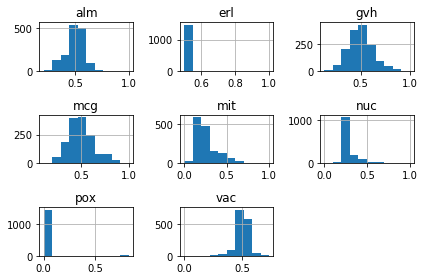

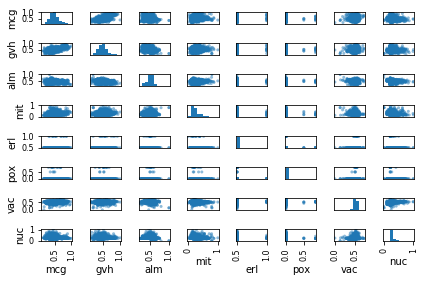

Unique values in each column: [81, 79, 53, 78, 2, 3, 48, 68, 10]
Number of dimensions of data frame: 2
The data type of column mcg is "float64"
The data type of column gvh is "float64"
The data type of column alm is "float64"
The data type of column mit is "float64"
The data type of column erl is "float64"
The data type of column pox is "float64"
The data type of column vac is "float64"
The data type of column nuc is "float64"
The data type of column site is "object"


In [39]:
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
import warnings
import sklearn.metrics as metrics
from sklearn import model_selection
from sklearn.base import clone

#Import csv to dataframe and give names to each of the columns
df = pd.read_csv("C:/Users/mmcgown/Downloads/Yeast.csv",names = ['sample','mcg', 'gvh', 'alm', 'mit', 'erl', 'pox', 'vac', 'nuc','site'])
#The first column is sample and we don't care about the sample since it's just a unique name for the row.
#It can be dropped since it provides no context for the data or a predictor for a model
df=df.drop(columns=['sample'])
target = 'site'
#Used to take an initial look at the categories of fields
print(df.head())
#Look at the end of the data
print(df.tail())

#Histogram to show overall distribution of each field, count vs values. Tight layout prevents overlap of axis labels.
df.hist()
plt.tight_layout()
plt.show()

#Scatter matrix to show the relation of each field to each other, erl/pox have little interaction since the above distribution is skewed
from pandas.plotting import scatter_matrix
scatter_matrix(df)
plt.tight_layout()
plt.show()


#Below shows the unique values in each column.
print('Unique values in each column:',[df[x].unique().shape[0] for x in df.columns])
#Erl/pox amino acids (columns 5,6) may be hard to identify by ML since they have almost no distribution
#It could still be the case that when they do occur they definitely correspond to the target column being a certain value
#The latter would still allow a model to use erl/pox to predict the target
#However, if that is true, it probably wouldn't be ones that rely on assumptions about the normal distribution of data
#The last value is site which we have 10 different site types

#ndim shows the dimensions of the dataframe which is just 2
print('Number of dimensions of data frame:',df.ndim)

#we can also check the data types of columns
#Sample will not be used and site will be the predicted target
#The non-target sites need to be all numeric and they are float64 so this is suitable for a ML model
for column in df.columns:
    print('The data type of column {} is "{}"'.format(column,df[column].dtype))

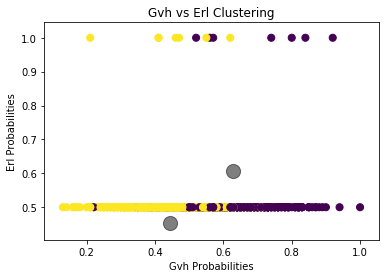

In [36]:
#To better test interaction of erl and pox we can use clustering to try to see by color if there appears a good separation
#It doesn't appear there is or distinct centers to their relationship
df2=df.drop(columns=['site'])
from sklearn.cluster import KMeans
#Fit kmeans to look for two distinct clusters
kmeans = KMeans(n_clusters=2)
kmeans.fit(df3)
y_kmeans = kmeans.predict(df3)

#Make a plot with two different colors of points size 50
plt.scatter(df2['gvh'], df2['erl'], c=y_kmeans, s=50, cmap='viridis')
plt.title('Gvh vs Erl Clustering')
plt.ylabel('Erl Probabilities')
plt.xlabel('Gvh Probabilities')

#Generate the two centers of color black and size 200
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

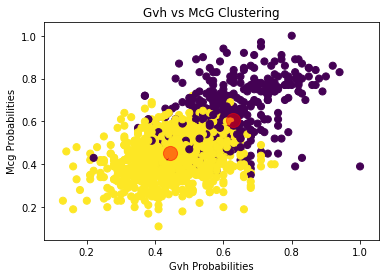

In [37]:
#gvh vs mcg does have a clearer scattering but still no space between clusters
#there is a lot of intermixed datapoints between the two centers (the black dots)
plt.scatter(df2['gvh'], df2['mcg'], c=y_kmeans, s=50, cmap='viridis')
plt.title('Gvh vs McG Clustering')
plt.ylabel('Mcg Probabilities')
plt.xlabel('Gvh Probabilities')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5)

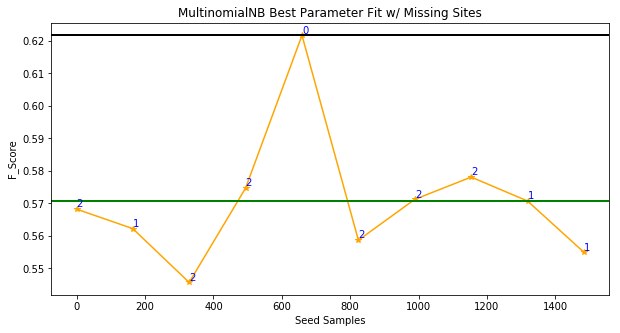

In [38]:
#***************************************************INPUTS***********************************************************************

#Below are Naive Bayes model types
#These are the three models we'll be testing. To best attempt F_score maxima, models will have no prior fit from previous attempts.
#GaussianNB is false in this way by default.
model_type = [BernoulliNB(fit_prior=False),GaussianNB(),MultinomialNB(fit_prior=False)]

#Neural nets can also be used but will take longer to converge
#model_type = [MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2)),MLPClassifier(solver='adam', alpha=1e-5,max_iter=10000,hidden_layer_sizes=(5, 2)),MLPClassifier(solver='sgd', alpha=1e-5,max_iter=10000,hidden_layer_sizes=(5, 2))]

#The model(s) will probably not be able to predict all amino acid sites. What is the max # of sites left unpredicted?
#Constraining to a number lower than 10 will result in more 0 fit scores and lower average fit scores
no_site_tolerance = 3
#Each model/train size/seeds converges on a different solution. How many subdivisions of starting points would you like to try?
seeds = 10
#The model(s) perform differently with different amounts of training. How many equally spaced percentages would you like to send?
train_steps = 10

#*******************************************************************************************************************************

#Makes ndarray of equally spaced train fractions to send to the model.
train_frac = np.linspace(0.1,0.9,train_steps)
#Makes ndarray of equally spaced starting points for the model to find convergence over the sample space.
states = np.linspace(0,df.shape[0],seeds, dtype=int)

#Identify the target field we are aiming to predict. In this case it is the amino acid site.
Y = df[target]
#Prepare to make the fields we aim to train & guess off of with our model as X. Remove the target site column.
df2 = df.drop(columns=[target])
#df2.columns is Index(['mcg', 'gvh', 'alm', 'mit', 'erl', 'pox', 'vac', 'nuc'], dtype='object').
#X is now every except the target site.
X = df[df2.columns[:]]

#This class assesses the fitness metrics of the trained model
def fit_model(X,Y,states,model,train_size,no_site_tolerance):
    #Iterate over each starting point seed, a different starting state
    for state in states:
        #Take the model type passed in
        clf = model
        #train_test_split randomly splits the data into a train_size fraction of how much data the model is trained with
        X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=train_size, random_state=state)
        #the model is fitted based on the training data
        clf = clf.fit(X_train, Y_train)
        #Ignoring warnings from model because it may not be able to have sufficient data to predict every site
        #The storage and constraining of ill_defined_sites is how we control/interpret what this warn concerns
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            #Precision & Recall are each different statistical measures of fitness
            #Precision is true positives/(true positives + false positives)
            precision = metrics.precision_score(Y_test, clf.predict(X_test), average='weighted')
            #Recall is true positives/(true positives + false negatives)
            recall    = metrics.recall_score(Y_test, clf.predict(X_test), average='weighted')
            #F score is the weighted mean of precision and recall
            f_score = 2/(1/precision+1/recall)
        #ill defined sites finds the set of sites that couldn't be predicted by the model this run
        ill_defined_sites = set(Y_test) - set(clf.predict(X_test))
        #that then allows us to constrain, from input, if the model is unfit no matter the f_score
        if len(ill_defined_sites) <= no_site_tolerance:
            #if there were enough predictable sites, pass in the f_score
            F = f_score
        else:
            #if not, give an F score of 0
            F = 0
        #Make two dictionaries with each starting model state as the keys
        #One dictionary is the resultant F score and the other is the ill defined sites e.g. MIT, NUC
        results_params[state],results_sites[state] = F, ill_defined_sites
    #Send these two dictionaries as the results
    return results_params, results_sites

#Set parameter names to be part of dictionary
params = ['F','state','train_size']
#Create empty dictionary of these parameter names
param_dict = {param: None for param in params}
#Create empty dictionary to be filled with each model to each parameter dictionary
model_dict = {model_name: param_dict for model_name in model_type}
#Iterate over input model types
for model in model_type:
    #Make empty dictionaries for interim use
    df3_params, df3_sites, results_params,results_sites = {},{},{},{}
    #Iterate over what fraction of data is fed to model
    for train_size in train_frac:
        #Obtain results as dictionaries of seed sample states to each resultant F_score/ill_defined_sites from the model
        results_params, results_sites = fit_model(X,Y,states,model,train_size,no_site_tolerance)
        #Put each result in a dictionary for the train size used
        df3_params.update({train_size:pd.Series(results_params)})
        #Separately store the missing sites of each run, can cross-reference dictionaries to get these later
        df3_sites.update({train_size:pd.Series(results_sites)})
        
    #Make empty dictionary to be filled with the best parameters for each model
    best = {}
    #Iterate over the train sizes to store the best F_score and its best parameters
    for key in df3_params.keys():
        #If this F_score is the first one or the maximum so far, store the settings
        if not best or best['F'] < df3_params[key].max():
            #Store this in the best dictionary
            best = {'train_size':key,'state':df3_params[key].idxmax(),'F':df3_params[key].max()}
    #If the highest F_score for that model was not 0
    if best['F']:
        #Store the best settings and F_score for each model
        model_dict.update({model:best})
    else:
        #Drop that model from the dictionary if it has no F_score
        model_dict.pop(model)
        
#Make empty dictionary to store the best model and its settings in
results_params, results_sites, best_model = {}, {}, {}

#Build a dictionary of the best model's settings based on F score
for model in model_dict.keys():
    #If dictionary empty or current iterated F score is better than stored value
    if not best_model or best_model['F'] < model_dict[model]['F']:
        #Store the train size
        model_train_size = model_dict[model]['train_size']
        #Store the random seed state
        model_state = model_dict[model]['state']
        #Store the best F score
        model_F = model_dict[model]['F']
        #Store the sites the best model doesn't include in its model
        best_sites = df3_sites[model_train_size][model_state]
        #Create the best model dictionary
        best_model = {'model': model,'state':model_state,'train_size':model_train_size,'F':model_F,'sites':best_sites}

#Fit the model with these best settings
results_params,results_sites = fit_model(X,Y,states,best_model['model'],best_model['train_size'],no_site_tolerance)

#Find out how much the avg_F of a model run with optimal parameters differs from the best F obtained from all models/train sizes/seeds
#Note that lower inputs of no_site_tolerance get more 0 F_scores, increasing the delta between avg_F and best_model F.
total = 0
for key in results_params.keys():
    total += results_params[key]
avg_F = total/len(results_params.keys())

#The rest is building the graph
#Import regular expressions
import re
#This pulls out the model name from the full name including all its settings
title = re.search('[^(]*',str(best_model['model']))
solver = re.search("solver='.*'",str(best_model['model']))
#Size of the figure in x and y
plt.figure(figsize=(10,5))
#Plot the F score against the random starting seed
plt.plot(results_params.keys(), results_params.values(), color='orange',marker='*')
#For each result we annotate the missing sites on the graph. These can be constrained by inputs
for key,value in zip(results_params.keys(),results_params.values()):
    #Annotate adds the missing sites, the rest is formatting/positioning
    plt.annotate(xy=(key,value),s=len(results_sites[key]),xytext=(key*1.00,value*1.00),ha='left',va='bottom',color='blue')
#Horizontal green line as the average of this best model run across starting seeds
plt.axhline(y=avg_F,linewidth=2, color='g')
#Horizontal black line as the best value
plt.axhline(y=best_model['F'],linewidth=2, color='black')
#Display the regular expression of the model plus more about the graph
#If MLPClassifier Neural Nets were used, want to include the solver type in the title
if (title.group(0) == "MLPClassifier"):
    plt.title(title.group(0) + " " + solver.group(0)+' Best Parameter Fit w/ Missing Sites')
#Otherwise, just show the type of Naive Bayes model that was best which is just in title alone
else:
    plt.title(title.group(0) + ' Best Parameter Fit w/ Missing Sites')
#Label x
plt.xlabel('Seed Samples')
#Label y
plt.ylabel('F_Score');

In [25]:
model_dict

{MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
        beta_2=0.999, early_stopping=False, epsilon=1e-08,
        hidden_layer_sizes=(10, 10), learning_rate='constant',
        learning_rate_init=0.001, max_iter=200, momentum=0.9,
        nesterovs_momentum=True, power_t=0.5, random_state=None,
        shuffle=True, solver='lbfgs', tol=0.0001, validation_fraction=0.1,
        verbose=False, warm_start=False): {'train_size': 0.1,
  'state': 156,
  'F': 0.6636227021420199},
 MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
        beta_2=0.999, early_stopping=False, epsilon=1e-08,
        hidden_layer_sizes=(10, 10), learning_rate='constant',
        learning_rate_init=0.001, max_iter=10000, momentum=0.9,
        nesterovs_momentum=True, power_t=0.5, random_state=None,
        shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
        verbose=False, warm_start=False): {'train_size': 0.14210526315789473,
  'state': 

In [6]:
best_model

{'model': MultinomialNB(alpha=1.0, class_prior=None, fit_prior=False),
 'state': 659,
 'train_size': 0.3666666666666667,
 'F': 0.6217000432704075,
 'sites': set()}